In [37]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv("MicrosoftStock.csv")
df.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [4]:
df.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


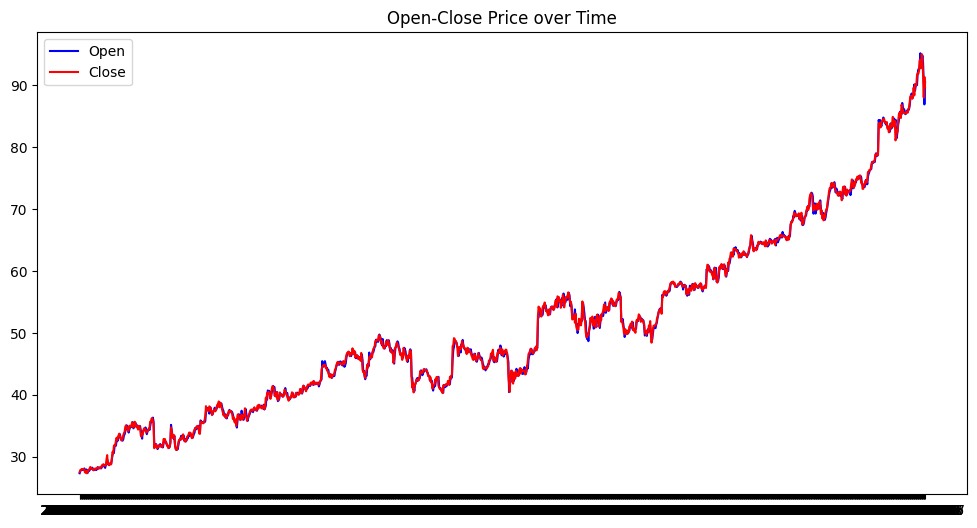

In [7]:
# Open and Close Prices of time

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['open'], label="Open",color="blue")
plt.plot(df['date'], df['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()

Text(0.5, 1.0, 'Stock Volume over Time')

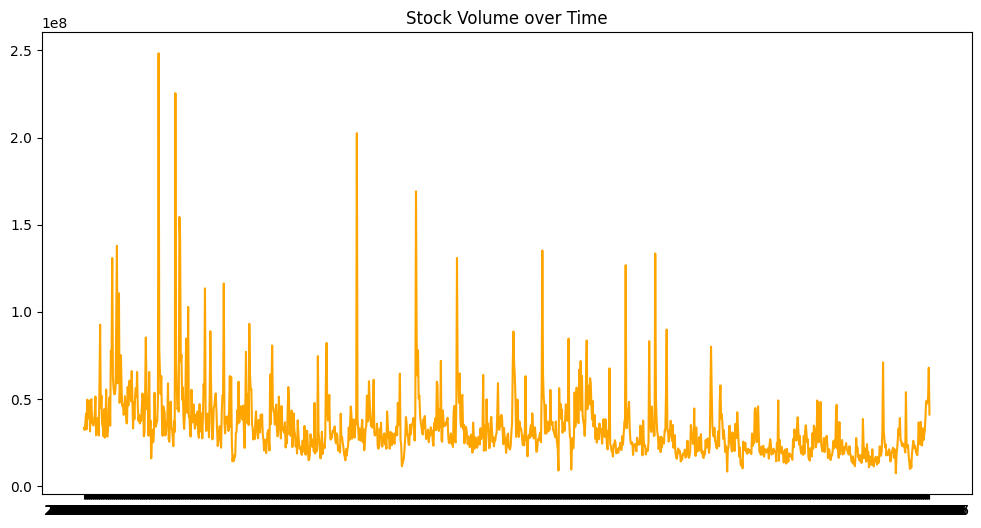

In [8]:
# Trading Volume (check for outliers)

plt.figure(figsize=(12,6))
plt.plot(df['date'],df['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")

In [9]:
# Drop non-numeric columns
numeric_data = df.select_dtypes(include=["int64","float64"])

Text(0.5, 1.0, 'Feature Correlation Heatmap')

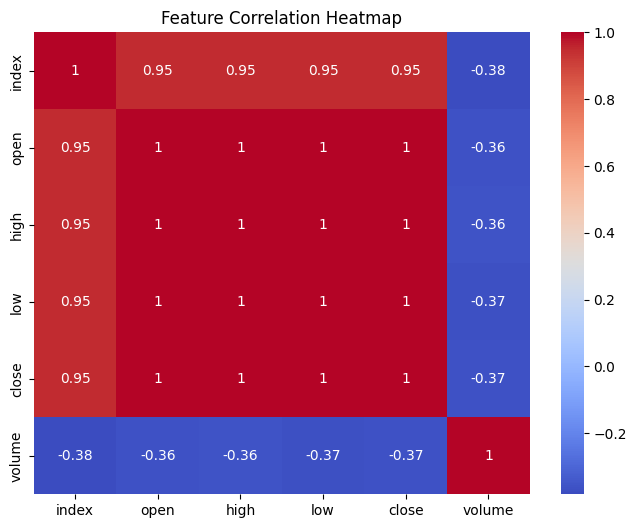

In [11]:
# Check for correlation between features
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")

In [16]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
from datetime import datetime

prediction = df.loc[
    (df['date'] > datetime(2013,1,1)) &
    (df['date'] < datetime(2018,1,1))
]

Text(0.5, 1.0, 'Price over time')

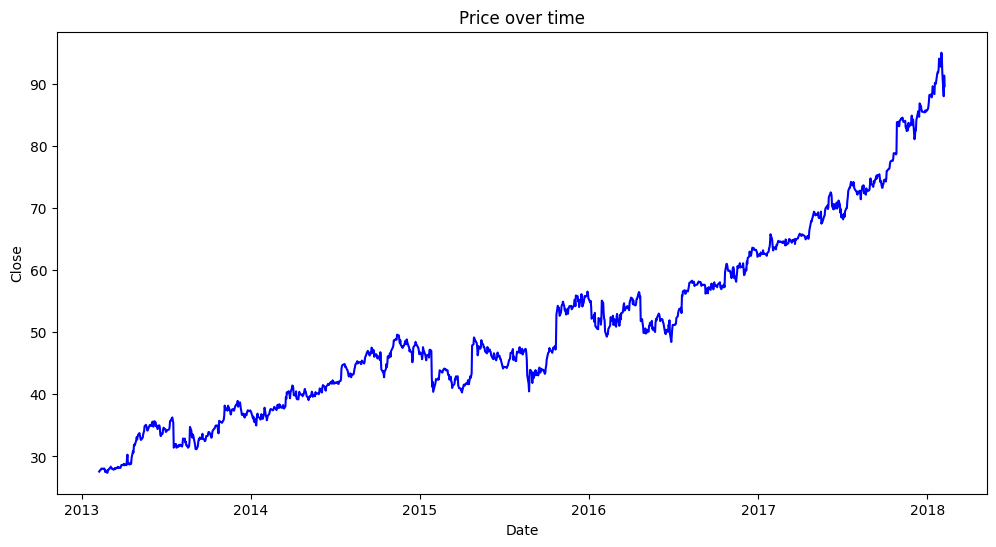

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")

In [24]:
# Prepare for the LSTM Model (Sequential)
stock_close = df.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [27]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [28]:
training_data = scaled_data[:training_data_len]

In [31]:
X_train, y_train = [], []

# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])

In [32]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [38]:
model = keras.models.Sequential()

# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))

# Final Output Layer
model.add(keras.layers.Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(loss="mae",
              optimizer="adam",
              metrics=[keras.metrics.RootMeanSquaredError()])

In [43]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.3484 - root_mean_squared_error: 0.4860
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1267 - root_mean_squared_error: 0.1757
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1184 - root_mean_squared_error: 0.1589
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1191 - root_mean_squared_error: 0.1587
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1095 - root_mean_squared_error: 0.1478
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1139 - root_mean_squared_error: 0.1559
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1002 - root_mean_squared_error: 0.1400
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.1032 - root_mean_squared_error: 0.1379
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.1112 - root_mean_squared_error: 0.1520
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1043 - root_mean_squared_error: 0.1448

In [44]:
# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

In [45]:
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [46]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

In [47]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


In [49]:
# Plotting data
train = df[:training_data_len]
test =  df[training_data_len:]

In [50]:
test = test.copy()

In [51]:
test['Predictions'] = predictions

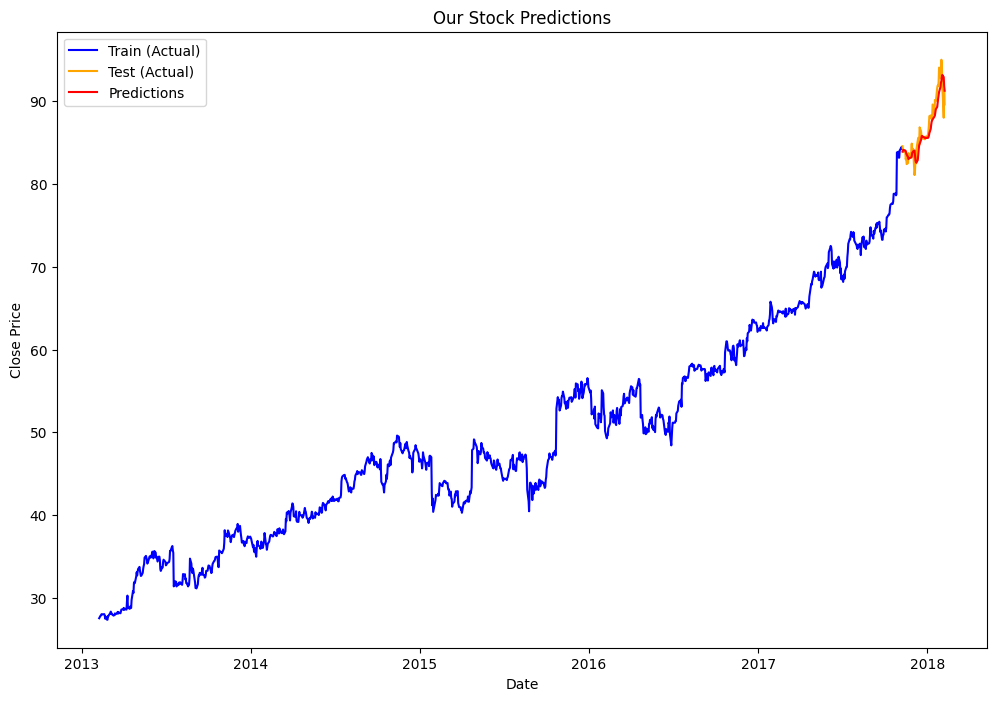

In [52]:
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['close'], test['Predictions'])
mse = mean_squared_error(test['close'], test['Predictions'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['close'] - test['Predictions']) / test['close'])) * 100

# Display the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 1.0518806162188117
Mean Squared Error (MSE): 2.0179036372393826
Root Mean Squared Error (RMSE): 1.420529351065786
Mean Absolute Percentage Error (MAPE): 1.196062260531263%
